In [1]:
import pandas as pd 
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

In [2]:
train_data = pd.read_csv('train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv('test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train_data.shape

(891, 12)

In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_data.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Let view the number of male against female who survived or died. Using the seaborn library, a chart is produced below. 

Text(0.5, 1.0, 'Survivors and deads count by class')

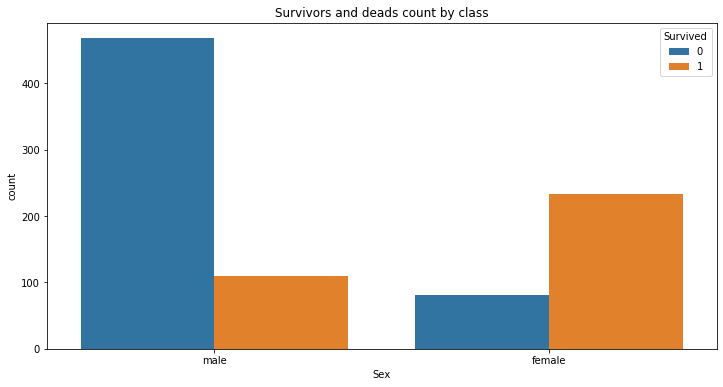

In [8]:
fig, ax1 = plt.subplots(1,figsize=(12,6))
sns.countplot(x='Sex', hue='Survived', data=train_data, ax=ax1).set_title('Survivors and deads count by class')

Since the ticket is a major determining factor in knowing the groups of family, we create two columns from the column ticket, by extract the first two letters of the ticket and by finding the total length of the ticket number. 

In [9]:
# Extract the first two letters
train_data['Ticket_lett'] = train_data.Ticket.apply(lambda x: x[:2])
test_data['Ticket_lett'] = test_data.Ticket.apply(lambda x: x[:2])
# Calculate ticket length
train_data['Ticket_len'] = train_data.Ticket.apply(lambda x: len(x))
test_data['Ticket_len'] = test_data.Ticket.apply(lambda x: len(x))

Two columns 'SibSp' and 'Parch' were merged together so as to get the size of each family on board. 

In [10]:
# Creation of a new Fam_size column
train_data['Fam_size'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['Fam_size'] = test_data['SibSp'] + test_data['Parch'] + 1

In [11]:
y = train_data['Survived']
features = ['Pclass', 'Fare', 'Embarked', 'Sex', 'Fam_size', 'Ticket_len', 'Ticket_lett' ]
X = train_data[features]
X_test = test_data[features]

In [12]:
numerical_cols = ['Fare']
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Fam_size', 'Ticket_len', 'Ticket_lett' ]

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Bundle preprocessing and modeling code 
titanic_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5))
                                  ])


# Preprocessing of training data, fit model 
titanic_pipeline.fit(X,y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

Cross validation score: 0.817


In [13]:
# Preprocessing of test data, get predictions
predictions = titanic_pipeline.predict(X_test)

In [ ]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print('Your submission was successfully saved!')